In [107]:
#Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

In [8]:
#Load Dataset
data = pd.read_csv('car_price_dataset.csv')
data.head()


,Make,Model,Year,Engine Size,Mileage,Fuel Type,Transmission,Price
0,Honda,Model B,2015,1.3,156577,Diesel,Manual,19240.996903
1,Audi,Model D,2017,1.1,192529,Electric,Manual,20281.779257
2,BMW,Model E,2000,3.7,156962,Electric,Automatic,19178.745634
3,Audi,Model D,2007,2.9,183057,Petrol,Manual,22090.033440
4,Audi,Model D,2000,3.4,108269,Petrol,Manual,21124.237648


In [58]:
# Data Cleaning
# Remove duplicates
data = data.drop_duplicates()

# Fill numeric columns with median
for col in data.select_dtypes(include=np.number):
    data[col] = data[col].fillna(data[col].median())

# Fill categorical columns with mode
for col in data.select_dtypes(include='object'):
    data[col] = data[col].fillna(data[col].mode()[0])

In [21]:
# Check remaining missing values
data.isna().sum()
# Check total number of missing values
data.isna().sum().sum()
# Check duplicates were removed
data.duplicated().sum()

np.int64(0)

In [20]:
print("Rows, Columns:", data.shape)

Rows, Columns: (10000, 8)


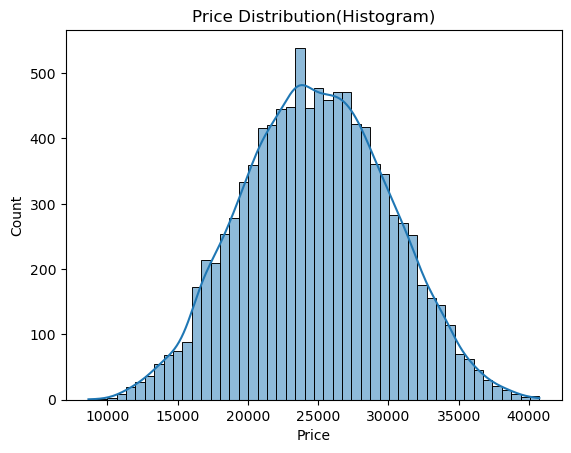

In [27]:
# Data Understanding 
# Histogram
plt.figure()
sns.histplot(data['Price'], kde=True)
plt.title('Price Distribution(Histogram)')
plt.show()

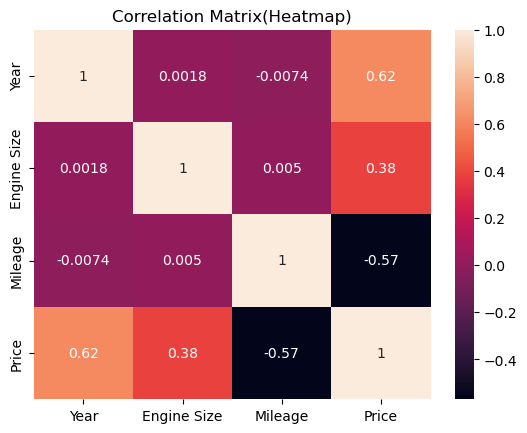

In [28]:
# Heatmap
plt.figure()
sns.heatmap(data.corr(numeric_only=True), annot=True)
plt.title('Correlation Matrix(Heatmap)')
plt.show()

In [76]:
# Feature Selection
X = data.drop('Price', axis=1)
y = data['Price']

numerical_features = ['Year', 'Engine_Size', 'Mileage']
categorical_features = ['Make', 'Model', 'Fuel_Type', 'Transmission']

# Preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [77]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42)

In [78]:
# Linear Regression Model 
linear_model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', LinearRegression())
])

linear_model.fit(X_train, y_train)
linear_pred = linear_model.predict(X_test)

In [79]:
# See R² score
r2 = r2_score(y_test, linear_pred)
print(f"R²   : {r2:.4f}")

R²   : 0.8508


In [80]:
# See MAE and RMSE
mae = mean_absolute_error(y_test, linear_pred)
mse = mean_squared_error(y_test, linear_pred)
rmse = np.sqrt(mse)

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 1608.0954361774004
RMSE: 1995.0189715016809


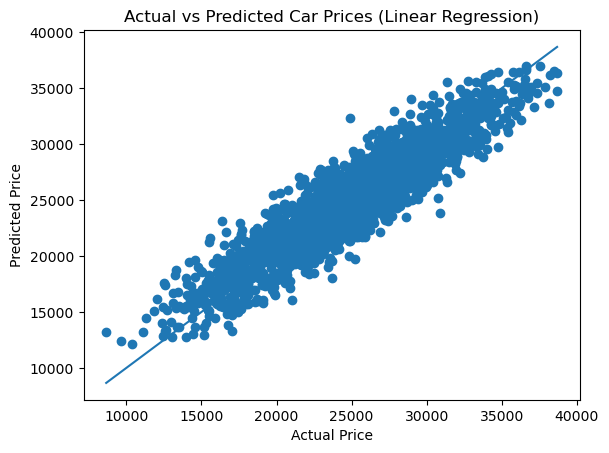

In [81]:
plt.figure()
plt.scatter(y_test, linear_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Car Prices (Linear Regression)")
plt.show()

In [88]:
# Random Forest Regressor
rf_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(random_state=42))
])

rf_params = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10],
    'regressor__min_samples_split': [2, 5]
}

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_params,
    cv=3,
    scoring='r2',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

rf_best = rf_grid.best_estimator_
rf_pred = rf_best.predict(X_test)

In [90]:
# Compute metrics
mae = mean_absolute_error(y_test, rf_pred)
rmse = np.sqrt(mean_squared_error(y_test, rf_pred))
r2 = r2_score(y_test, rf_pred)

# Print
print(f"Random Forest Evaluation Metrics:")
print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.4f}")

Random Forest Evaluation Metrics:
MAE  : 1672.48
RMSE : 2080.30
R²   : 0.8377


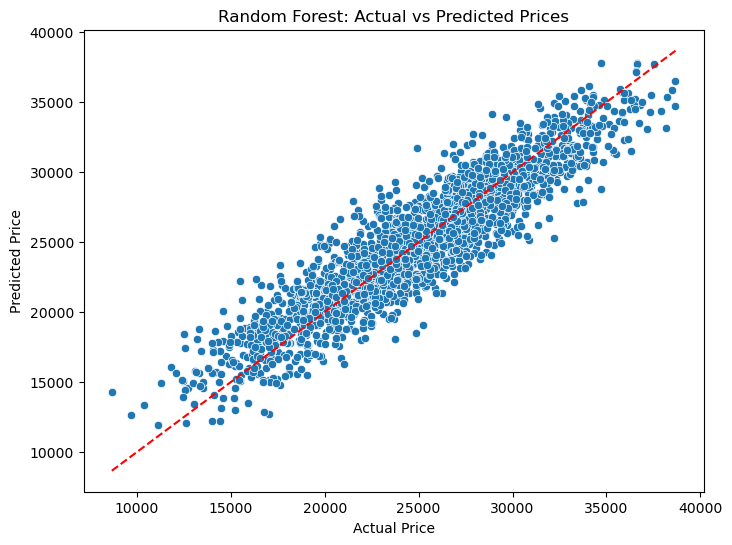

In [91]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=rf_pred)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs Predicted Prices")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # diagonal line
plt.show()

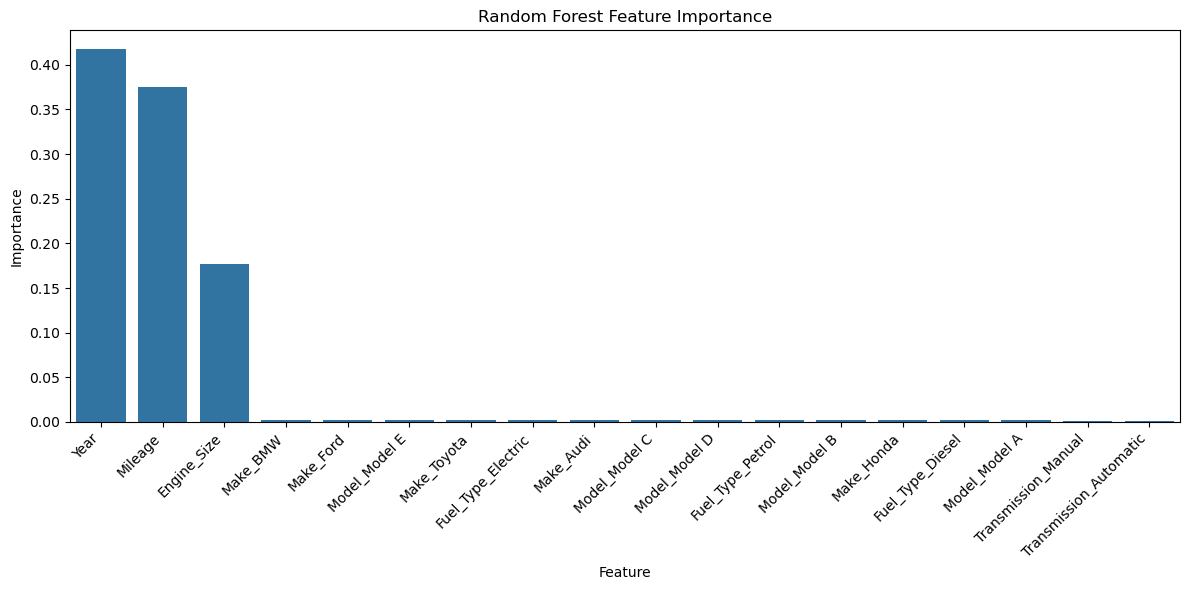

In [92]:
# Get feature importances
importances = rf_best.named_steps['regressor'].feature_importances_

# Get feature names from preprocessor
num_features = numerical_features
cat_features = rf_best.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
feature_names = list(num_features) + list(cat_features)

# Create DataFrame
feat_imp = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x='Feature', y='Importance', data=feat_imp)
plt.title("Random Forest Feature Importance")
plt.xticks(rotation=45, ha='right')  # Rotate labels for readability
plt.tight_layout()
plt.show()


In [101]:
# Results Comparison
evaluate_model('Linear Regression', y_test, linear_pred)
evaluate_model('Random Forest Regression', y_test, rf_pred)

Linear Regression Performance
MAE: 1608.0954361774004
MSE: 3980100.6966516245
R2 Score: 0.850752246107692
Random Forest Regression Performance
MAE: 1672.4754665264031
MSE: 4327647.533583226
R2 Score: 0.8377197655907906


In [112]:
# Neural Network Regressor
nn_model = Pipeline(steps=[
('preprocessor', preprocessor),
('regressor', MLPRegressor(
hidden_layer_sizes=(64, 32),
activation='relu',
solver='adam',
max_iter=500,
random_state=42
))
])
nn_model.fit(X_train, y_train)
nn_pred = nn_model.predict(X_test)

# Model Evaluation
evaluate_model('Neural Network (ANN)', y_test, nn_pred)

Neural Network (ANN) Performance
MAE: 1608.249349284718
MSE: 3980914.8489252212
R2 Score: 0.850721716629314


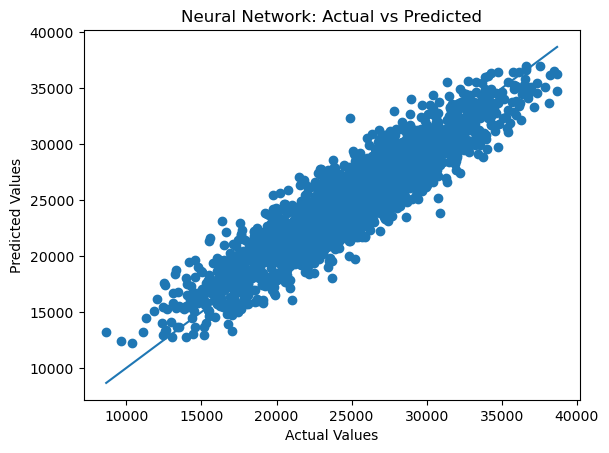

In [113]:
plt.figure()
plt.scatter(y_test, nn_pred)
plt.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()])
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Neural Network: Actual vs Predicted")
plt.show()

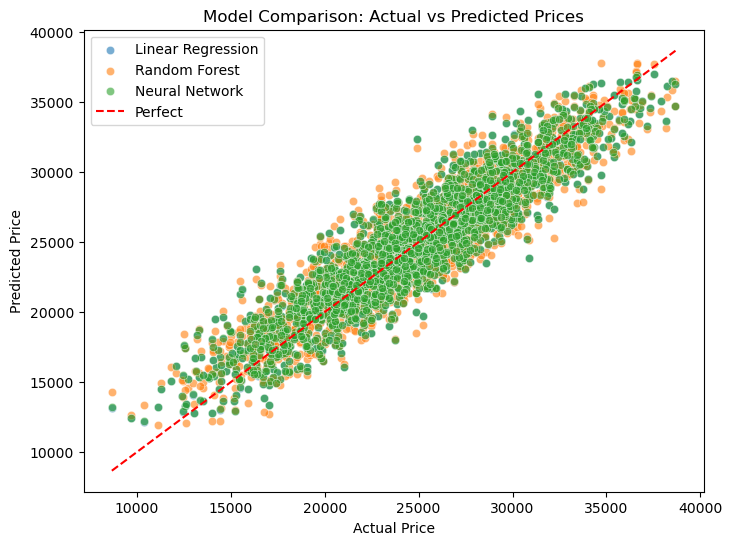

In [114]:
# Comparing all three models
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=linear_pred, label='Linear Regression', alpha=0.6)
sns.scatterplot(x=y_test, y=rf_pred, label='Random Forest', alpha=0.6)
sns.scatterplot(x=y_test, y=nn_pred, label='Neural Network', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Model Comparison: Actual vs Predicted Prices")
plt.legend()
plt.show()

In [115]:
# Prediction for New Car
new_car = pd.DataFrame({
'Make': ['Toyota'],
'Model': ['Corolla'],
'Fuel_Type': ['Petrol'],
'Transmission': ['Manual'],
'Year': [2019],
'Mileage': [35000],
'Engine_Size': [1.8]
})


predicted_price = rf_best.predict(new_car)
print("Predicted Car Price:", predicted_price[0])

Predicted Car Price: 31380.707472729115


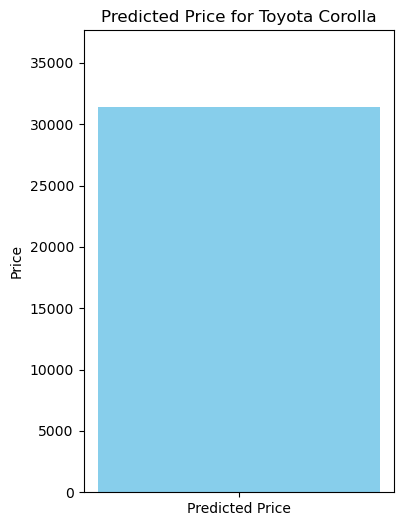

In [117]:
predicted_price = rf_best.predict(new_car)[0]

plt.figure(figsize=(4,6))
plt.bar('Predicted Price', predicted_price, color='skyblue')  # Vertical bar
plt.ylabel('Price')
plt.title(f"Predicted Price for {new_car['Make'][0]} {new_car['Model'][0]}")
plt.ylim(0, predicted_price*1.2)  # Add some headroom
plt.show()